# 0) Loading Modules & Data

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Embedding, Dropout
from keras.utils import to_categorical

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/FYP")

In [ ]:
# Loading feature files
vocab_level_features_df = pd.read_csv("../Data/Features/vocab_level_features_df.csv")
readability_features_df = pd.read_csv("../Data/Features/readability_features_df.csv")
sentence_vectors = np.load('../Data/Features/sentence_vectors_representation.npy', allow_pickle=True)
chapter_level_features_df = pd.read_csv("../Data/Features/chapter_level_features_df.csv")
final_train_data = pd.read_csv("../data/Processed/final_train_data.csv")

In [ ]:
# Adding Essay Set to Vocab
vocab_level_features_df["essay_set"] = final_train_data["essay_set"]

In [ ]:
import tensorflow as tf
from sklearn.metrics import cohen_kappa_score
from tensorflow.keras.metrics import Metric
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Bidirectional, LSTM, concatenate, Flatten, Dropout

# Define the inputs
vocab_level_input = Input(shape=(vocab_level_features_df.shape[1], 1), name='vocab_level_input')
readability_input = Input(shape=(readability_features_df.shape[1], 1), name='readability_input')
sentence_vector_input = Input(shape=(sentence_vectors[0].shape[0], 1), name='sentence_vector_input')
chapter_level_input = Input(shape=(chapter_level_features_df.shape[1], 1), name='chapter_level_input')

# CNN for vocabulary level features
cnn_vocab_level = Conv1D(filters=64, kernel_size=3, activation='relu')(vocab_level_input)
cnn_vocab_level = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_vocab_level)
cnn_vocab_level = Dropout(0.2)(cnn_vocab_level)
cnn_vocab_level = Flatten()(cnn_vocab_level)  # Flatten the output for the dense layer

# CNN for readability
cnn_readability = Conv1D(filters=64, kernel_size=3, activation='relu')(readability_input)
cnn_readability = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_readability)
cnn_readability = Dropout(0.2)(cnn_readability)
cnn_readability = Flatten()(cnn_readability)

# BiLSTM for sentence vectors
lstm_sentence_vector = Bidirectional(LSTM(64, return_sequences=True))(sentence_vector_input)
lstm_sentence_vector = Bidirectional(LSTM(64))(lstm_sentence_vector)

# First fusion
sentence_level_output = concatenate([cnn_readability, lstm_sentence_vector])

# BiLSTM for chapter level features
lstm_chapter_level = Bidirectional(LSTM(128, return_sequences=True))(chapter_level_input)
lstm_chapter_level = Bidirectional(LSTM(128))(lstm_chapter_level)

# Final fusion
final_fusion = concatenate([cnn_vocab_level, sentence_level_output, lstm_chapter_level])

# Output layer
output = Dense(16, activation='relu')(final_fusion)
output = Dense(1, activation='linear')(output)

# Building the model
model = Model(inputs=[vocab_level_input, readability_input, sentence_vector_input, chapter_level_input], outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 readability_input (InputLa  [(None, 29, 1)]              0         []                            
 yer)                                                                                             
                                                                                                  
 vocab_level_input (InputLa  [(None, 28, 1)]              0         []                            
 yer)                                                                                             
                                                                                                  
 conv1d_10 (Conv1D)          (None, 27, 64)               256       ['readability_input[0][0]']   
                                                                                            

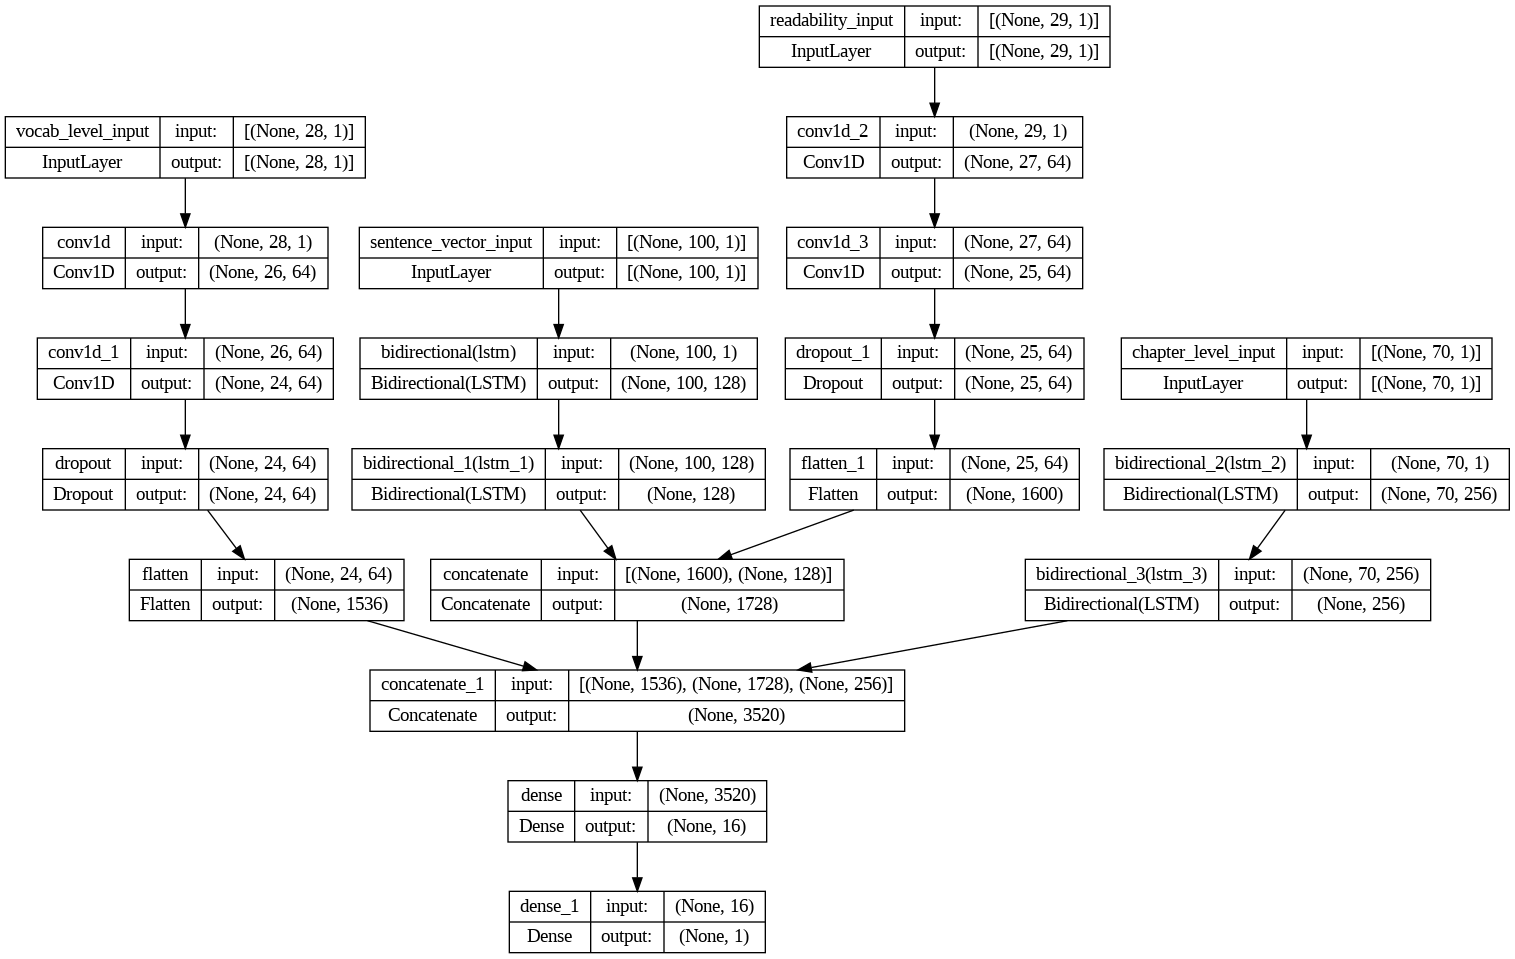

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Reshaping data
vocab_level_features_df = vocab_level_features_df.to_numpy().reshape((-1, vocab_level_features_df.shape[1], 1))
readability_features_df = readability_features_df.to_numpy().reshape((-1, readability_features_df.shape[1], 1))
chapter_level_features_df = chapter_level_features_df.to_numpy().reshape((-1, chapter_level_features_df.shape[1], 1))
sentence_vectors = np.array([i.reshape(-1, 1) for i in sentence_vectors])

In [ ]:
targets = final_train_data['domain1_score'].values

# Spliting into training and testing sets
vocab_train, vocab_test, readability_train, readability_test, sentence_train, sentence_test, chapter_train, chapter_test, y_train, y_test = train_test_split(
    vocab_level_features_df,
    readability_features_df,
    sentence_vectors,
    chapter_level_features_df,
    targets,
    test_size=0.2,
    random_state=42
)

In [ ]:
# Compiling the model with a custom loss function and optimizer
model.compile(optimizer='adam', loss='mae', metrics=["mse", "mae"])

# Training the model
history = model.fit(
    [vocab_train, readability_train, sentence_train, chapter_train],
    y_train,
    validation_data=([vocab_test, readability_test, sentence_test, chapter_test], y_test),
    batch_size=128,
    epochs=200
)

Epoch 1/200
82/82 [==============================] - 25s 108ms/step - loss: 4.8717 - mse: 71.4381 - mae: 4.8717 - val_loss: 3.4682 - val_mse: 29.0008 - val_mae: 3.4682
Epoch 2/200
82/82 [==============================] - 4s 47ms/step - loss: 3.0853 - mse: 27.5916 - mae: 3.0853 - val_loss: 2.8528 - val_mse: 21.1493 - val_mae: 2.8528
Epoch 3/200
82/82 [==============================] - 3s 41ms/step - loss: 2.8032 - mse: 23.7976 - mae: 2.8032 - val_loss: 2.1812 - val_mse: 17.1612 - val_mae: 2.1812
Epoch 4/200
82/82 [==============================] - 4s 45ms/step - loss: 2.1663 - mse: 18.0937 - mae: 2.1663 - val_loss: 1.9932 - val_mse: 15.3444 - val_mae: 1.9932
Epoch 5/200
82/82 [==============================] - 4s 43ms/step - loss: 1.9884 - mse: 16.0480 - mae: 1.9884 - val_loss: 1.8669 - val_mse: 14.8277 - val_mae: 1.8669
Epoch 6/200
82/82 [==============================] - 4s 49ms/step - loss: 1.8500 - mse: 14.1920 - mae: 1.8500 - val_loss: 1.7396 - val_mse: 13.2739 - val_mae: 1.7396
Ep

In [ ]:
# Saving Trained Model for Later Use
model.save("../Outputs/Model/trained_model.keras")

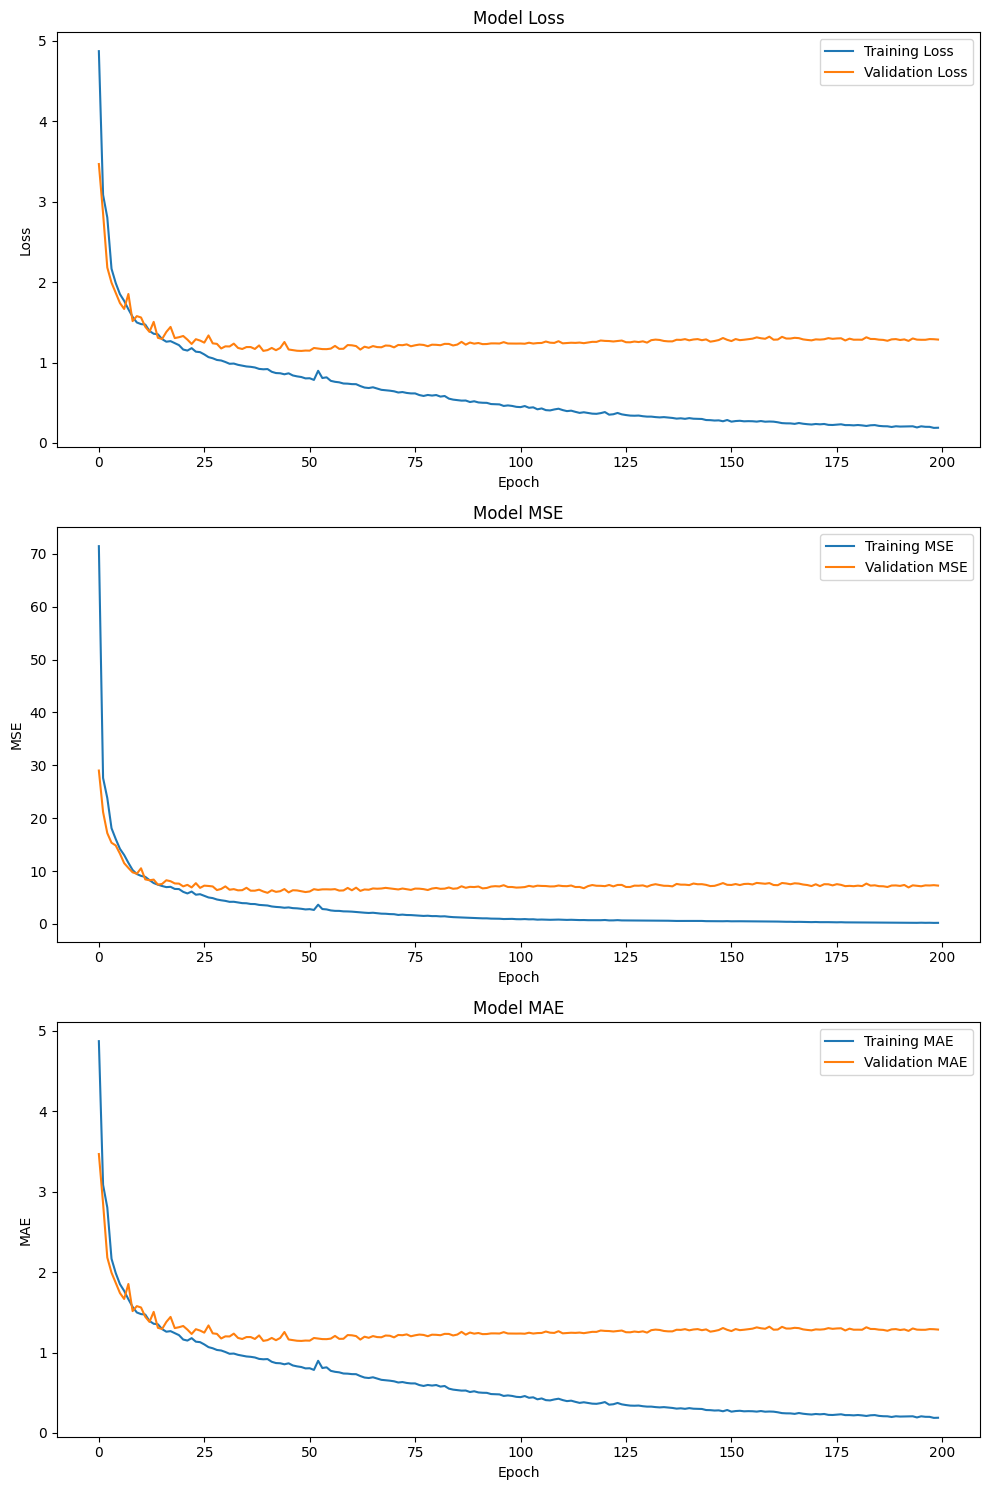

In [ ]:
# Plotting the history of the model
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Model Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# MSE
axs[1].plot(history.history['mse'], label='Training MSE')
axs[1].plot(history.history['val_mse'], label='Validation MSE')
axs[1].set_title('Model MSE')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MSE')
axs[1].legend()

# MAE
axs[2].plot(history.history['mae'], label='Training MAE')
axs[2].plot(history.history['val_mae'], label='Validation MAE')
axs[2].set_title('Model MAE')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('MAE')
axs[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Making Prediction
y_pred = model.predict([vocab_test, readability_test, sentence_test, chapter_test], verbose=0)
y_pred = list(y_pred[:, 0])
y_test = list(y_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, cohen_kappa_score

# Calculating metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
qwk = cohen_kappa_score(y_test, [round(pred) for pred in y_pred], weights='quadratic')

print("MSE:", mse)
print("MAE:", mae)
print("R2 Score:", r2)
print("QWK:", qwk)

MSE: 7.241111966850322
MAE: 1.285535216213172
R2 Score: 0.9069957750939406
QWK: 0.952524673273591


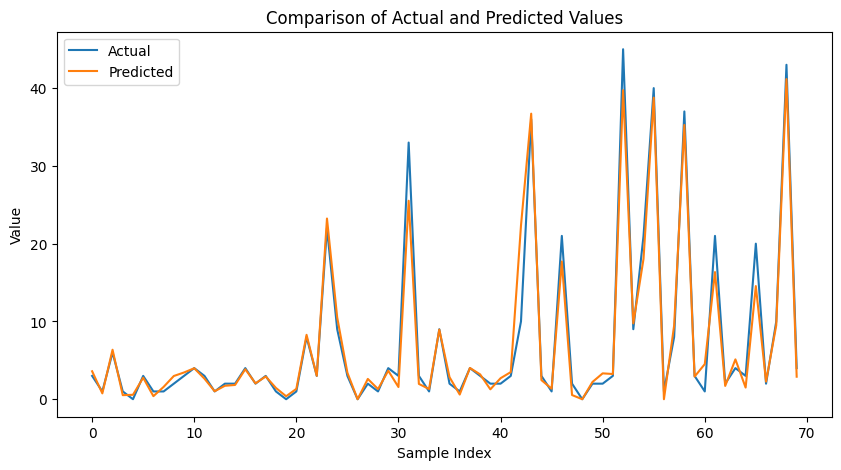

In [ ]:
import matplotlib.pyplot as plt

# Plotting the 100 samples from test and pred as lines
plt.figure(figsize=(10, 5))
plt.plot(y_test[30:100], label='Actual')
plt.plot(y_pred[30:100], label='Predicted')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
df_pred = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
df_pred.to_csv("predictions.csv", index=False)
df_pred.iloc[30:40]

,Actual,Predicted
30,3,3.594370
31,1,0.751329
32,6,6.363010
33,1,0.522999
34,0,0.568323
35,3,2.762148
36,1,0.391868
37,1,1.582880
38,2,2.986005
39,3,3.438743


from matplotlib import pyplot as plt
_df_0['Actual'].plot(kind='hist', bins=20, title='Actual')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Predicted'].plot(kind='hist', bins=20, title='Predicted')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Actual', y='Predicted', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Actual'].plot(kind='line', figsize=(8, 4), title='Actual')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['Predicted'].plot(kind='line', figsize=(8, 4), title='Predicted')
plt.gca().spines[['top', 'right']].set_visible(False)